In [74]:
import xgboost
import pickle
import shap

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skrebate import MultiSURF

%matplotlib inline
shap.initjs()

In [47]:
feature_categories = [
    'Shape', 
    'Clinical',
    'First Order', 
    'GLCM', 
    'GLRLM', 
    'GLSZM', 
    'GLDM', 
    'NGTDM', 
    'PET parameter',
]

In [45]:
def get_palette_colour(label):
    
    palette = sns.color_palette('colorblind', n_colors=len(feature_categories))
    mapping = {
        'Shape': palette[0], 
        'Clinical': palette[1],
        'First Order': palette[2], 
        'GLCM': palette[3], 
        'GLRLM': palette[4], 
        'GLSZM': palette[5], 
        'GLDM': palette[6], 
        'NGTDM': palette[7], 
        'PET parameter': palette[8]
    }
    return mapping[label]

In [42]:
def feature_categories_from_labels(labels):    
    """Translates feature labels into feature categories."""
    keys = []
    for label in labels:
        if 'shape' in label:
            keys.append('Shape')
        elif 'firstorder' in label:
            keys.append('First Order')
        elif 'glcm' in label:
            keys.append('GLCM')
        elif 'glrlm' in label:
            keys.append('GLRLM')
        elif 'glszm' in label:
            keys.append('GLSZM')
        elif 'gldm' in label:
            keys.append('GLDM')
        elif 'ngtdm' in label:
            keys.append('NGTDM')
        elif 'PETparam' in label:
            keys.append('PET parameter')
        else:
            keys.append('Clinical')

    return keys

In [52]:
def format_feature_labels(labels):
    """Process raw feature labels."""
    prep_labels = []
    for label in labels:
        #print(label)
        comps = label.split('_')
        if len(comps) == 1:
            prep_labels.append(label.title())
        elif len(comps) == 2:
            new_label = f'{comps[0]}: {comps[1]}'
            prep_labels.append(new_label)
        elif len(comps) == 3:
            filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = '{}'.format(name)
            else:
                new_label = '{}'.format(name)
            prep_labels.append(new_label)
        elif len(comps) == 4:
            image_type, filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = f'{image_type} {name}'
            else:
                new_label = f'{image_type} {name}'
            prep_labels.append(new_label)
        elif len(comps) == 5:
            image_type, _, _, name, _ = comps
            if len(name) > 15:
                new_label = f'{image_type} {name}'
            else:
                new_label = f'{image_type} {name}'
            prep_labels.append(new_label)
        else:
            raise ValueError('Label more than 5 comps!')
            
    return prep_labels

In [109]:
def extract_ranks(ranks, feature_labels, clinical):
    """Collects selected feature votes from experimental results.
    
    Args:
        votes (): The votes column from results DataFrame.
        X (): The feature matrix used in the experiment.
        feature_labels(): 
    
    """
     
    data = pd.DataFrame({'ranks': ranks, 'labels': feature_labels})

    # Group the encoded clinical variables and scale by number of encoded members:
    # 1. Extract and format the clinical feature votes.
    # 2. Remove the encoded clinical feature votes from the vote bookeeper.
    # 3. Insert the formatted clinical feature votes.

    # To accumulate votes.
    votes_noncoded_clinical = {
        'ICD-10': 0, 
        'T Stage': 0, 
        'N Stage': 0, 
        'Stage': 0, 
        'Histology': 0,
        'HPV': 0,
        'ECOG': 0,
        'Charlson': 0,
        'Cisplatin': 0,
        'Stage': 0
    }
    # Delete row from data.
    num_encodings_tracker = {
        'ICD-10': 0, 
        'T Stage': 0, 
        'N Stage': 0, 
        'Stage': 0, 
        'Histology': 0,
        'HPV': 0,
        'ECOG': 0,
        'Charlson': 0,
        'Cisplatin': 0,
    }
    to_drop = []
    for col in clinical.columns:
        match = data[data['labels'] == col]
        if not match.empty:
            vote, label = np.squeeze(match.values)
            if 'ICD-10' in label:
                votes_noncoded_clinical['ICD-10'] += float(vote)
                num_encodings_tracker['ICD-10'] += 1
                to_drop.append(int(match.index[0]))
            if 'Histology' in label:
                votes_noncoded_clinical['Histology'] += float(vote)
                num_encodings_tracker['Histology'] += 1
                to_drop.append(int(match.index[0]))
            if 'HPV' in label:
                votes_noncoded_clinical['HPV'] += float(vote)
                num_encodings_tracker['HPV'] += 1    
                to_drop.append(int(match.index[0]))
            if 'ECOG' in label:
                votes_noncoded_clinical['ECOG'] += float(vote)
                num_encodings_tracker['ECOG'] += 1   
                to_drop.append(int(match.index[0]))
            if 'Charlson' in label:
                votes_noncoded_clinical['Charlson'] += float(vote)
                num_encodings_tracker['Charlson'] += 1 
                to_drop.append(int(match.index[0]))
            if 'Cisplatin' in label:
                votes_noncoded_clinical['Cisplatin'] += float(vote)
                num_encodings_tracker['Cisplatin'] += 1  
                to_drop.append(int(match.index[0]))
            if 'T Stage' in label:
                votes_noncoded_clinical['T Stage'] += float(vote)
                num_encodings_tracker['T Stage'] += 1  
                to_drop.append(int(match.index[0]))
            if 'N Stage' in label:
                votes_noncoded_clinical['N Stage'] += float(vote)
                num_encodings_tracker['N Stage'] += 1 
                to_drop.append(int(match.index[0]))
            if 'Stage' in label:
                if 'T Stage' in label:
                    pass
                elif 'T Stage' in label:
                    pass
                else:
                    votes_noncoded_clinical['Stage'] += float(vote)
                    num_encodings_tracker['Stage'] += 1 
                    to_drop.append(int(match.index[0]))

    # Scale votes by the number of encodings.
    row_idx = data.index[-1] + 1
    for num, (key, value) in enumerate(votes_noncoded_clinical.items()):
        votes_noncoded_clinical[key] /= (num_encodings_tracker[key] + 1e-20)

    # Drop votes on encoded clinical variable.
    data.drop(to_drop, inplace=True, axis=0)
    data.reset_index(drop=True, inplace=True)

    tmp_df = pd.DataFrame([votes_noncoded_clinical.values(), votes_noncoded_clinical.keys()]).T
    tmp_df.columns = ['ranks', 'labels']
    tmp_df.index = np.arange(data.index[-1] + 1, data.index[-1] + 1 + tmp_df.shape[0])

    data = data.append(tmp_df)

    return data

In [110]:
X = pd.read_csv(
    './../../data_source/to_analysis/hpv_splitting/all_features_orig_images_icc_dropped_hpv_group_b.csv',
    index_col=0
)
y = pd.read_csv('../../data_source/to_analysis/hpv_splitting/dfs_orig_images_hpv_group_b.csv', index_col=0)
y = np.squeeze(y.values)

clinical = pd.read_csv('./../../data_source/to_analysis/clinical_params.csv', index_col=0)
clinical = clinical.loc[X.index, :]

X.shape, y.shape, clinical.shape

((67, 152), (67,), (67, 42))

# MultiSURF

In [111]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
selector = MultiSURF(n_features_to_select=26)
selector.fit(X_std, y)

/anaconda3/envs/biorad/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/biorad/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


MultiSURF(discrete_threshold=10, n_features_to_select=26, n_jobs=1,
     verbose=False)

In [124]:
ranks = extract_ranks(selector.feature_importances_, X.columns, clinical)
ranks.head()

,ranks,labels
0,-0.0132437,Age
1,-0.00145105,Years Smoking
2,0.0225425,Naxogin Days
3,-0.00236875,Sex_M
4,0.0153014,original_shape_Elongation


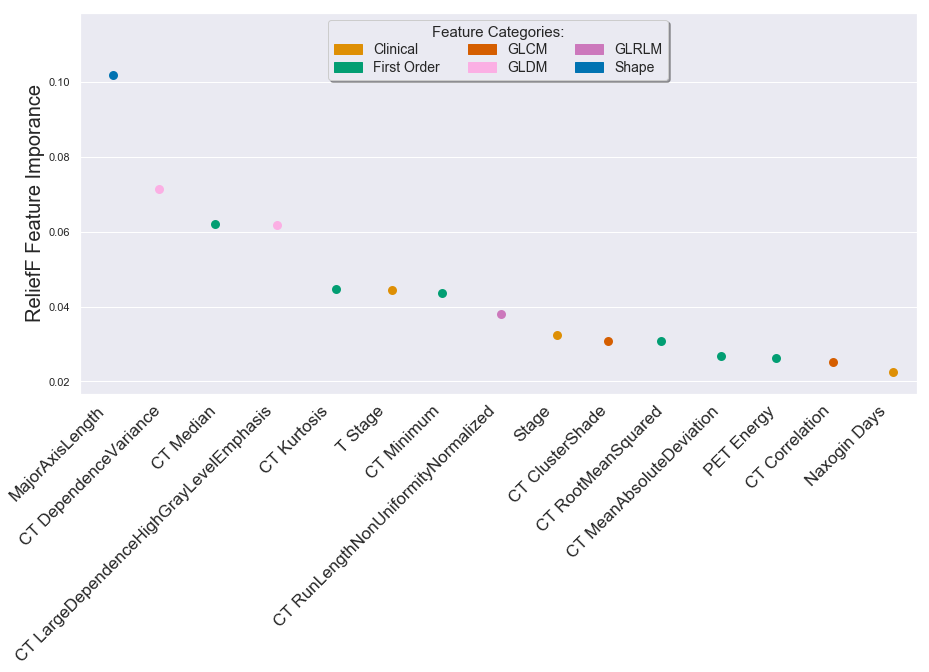

In [137]:
# Importance of each feature when MultiSURF is applied to all training data.
sns.set()

n = 15
idx = np.argsort(ranks.iloc[:, 0])[::-1][:n]
sub_data = ranks.iloc[idx, 0]
fnames = format_feature_labels(ranks.iloc[idx, 1])

keys = feature_categories_from_labels(ranks.iloc[idx, 1])
  
feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     

handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]
plt.figure(figsize=(15, 7))
fig = sns.stripplot(  
    x=fnames,
    y=sub_data,
    size=9,
    hue=keys,
    palette=feature_category_to_colour
)

feature_id = np.arange(n)
plt.ylabel('ReliefF Feature Imporance', fontsize=20)
plt.xlabel('')
plt.xticks(np.arange(np.size(fnames)), fnames, fontsize=17, rotation=45, ha='right')

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=3,
    labelspacing=0.25
)
plt.savefig(
    '../../figures/feature_importances/multi_surf_feat_rank.png', 
    format='png', dpi=100, bbox_inches='tight'
)

# SHAP Values

In [5]:
model = pickle.load(open('../../data_source/results/feature_importance/xgb.pickle.dat', 'rb'))
explainer = pickle.load(open('../../data_source/results/feature_importance/xgb_explainer.pickle.dat', 'rb'))
shap_values = np.load('../../data_source/results/feature_importance/shap_values.npy')

In [6]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :], show=False)
#plt.savefig('../../figures/feature_importances/shap_force_single.png', format='png', dpi=100, bbox_inches='tight')

In [7]:
shap.force_plot(explainer.expected_value, shap_values, X, show=False)
#plt.savefig('../../figures/feature_importances/shap_force_all.png', format='png', dpi=100, bbox_inches='tight')

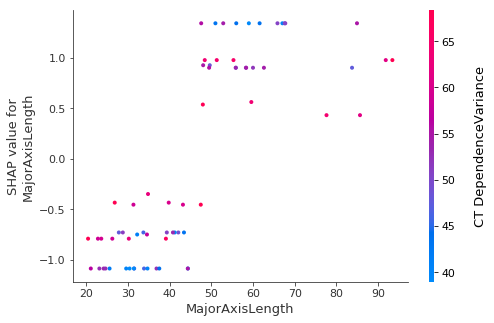

In [8]:
fig = shap.dependence_plot(
    ind='MajorAxisLength', 
    shap_values=shap_values, 
    features=X, 
    show=False
)
plt.savefig('../../figures/feature_importances/shap_feat_dependence.png', format='png', dpi=200, bbox_inches='tight')

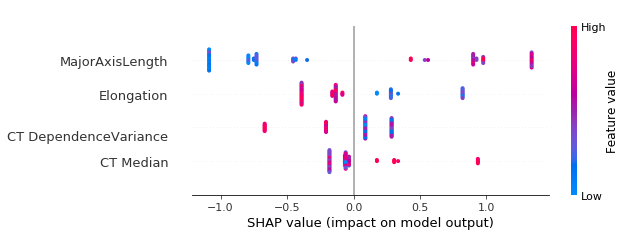

In [9]:
fig = shap.summary_plot(
    shap_values=shap_values, 
    features=X, 
    max_display=4,
    show=False
)
plt.savefig('../../figures/feature_importances/shap_summary.png', format='png', dpi=200, bbox_inches='tight')

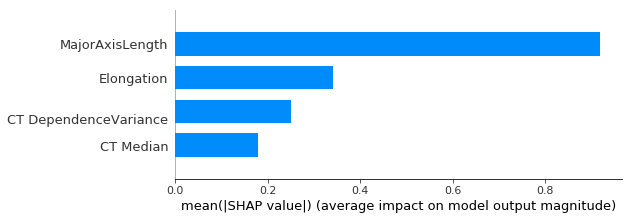

In [10]:
fig = shap.summary_plot(
    shap_values, 
    X, 
    plot_type='bar', 
    max_display=4,
    show=False
)
plt.savefig('../../figures/feature_importances/shap_summary_bar.png', format='png', dpi=200, bbox_inches='tight')

In [11]:
#X.columns[shap_values.sum(axis=0) != 0]

[<matplotlib.lines.Line2D at 0x1c264423c8>]

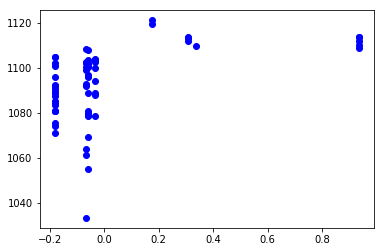

In [37]:
# CT Median feature.
plt.figure()
plt.plot(shap_values[:, 56], X.iloc[:, 56], 'bo')